# COS 470 - Image Processing and Computer Vision

#  Sports Image Classification
### Authors: Ethan Gilles, Josh Thyng, Sam Fickett

---

## Importing libraries

In [13]:
import os
import sys
import math
import torch
import torchvision
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.optim as optim
from torchinfo import summary
import cv2


## Setup cuda drivers

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cpu')

## Data pre-processing

In [15]:
# Apply image transformations to the data sets to make them more robust.
img_transforms  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.25), # 25% chance for horizontal flip
    transforms.RandomVerticalFlip(p=0.25),   # 25% change for vertical flip
    transforms.RandomRotation(degrees=45),   # Rotates to a random angle between -45 and 45 degrees
    transforms.ToTensor(),                   # Makes it a PyTorch Tensor

    # Normalization values reused from a source on Kaggle
    # other norm values could be used depending on accuracy:
    # Other Source -> mean=[-0.0932, -0.0971, -0.1260], std=[0.5091, 0.4912, 0.4931]
    # ImageNet -> mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use image folder to load the images and apply transforms
train_data = ImageFolder(root='train', transform=img_transforms)
validation_data = ImageFolder(root='valid', transform=img_transforms)
test_data = ImageFolder(root='test', transform=img_transforms)

len(train_data), len(validation_data), len(test_data)

(13492, 500, 505)

## Create / Visualize Data

In [16]:
# Assign training variables
# Batch-size
batch = 64
# Number of processes used to load the data
workers = 2

train_dataloader = DataLoader(dataset=train_data, batch_size=batch, shuffle=True, num_workers=workers)
validation_dataloader = DataLoader(dataset=validation_data, batch_size=batch, shuffle=False, num_workers=workers)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch, shuffle=False, num_workers=workers)


In [17]:
# Visualization function
def visualize(dataloader):
  images, labels = next(iter(dataloader))
  grid = make_grid(images, nrow=8, normalize=True)
  plt.figure(figsize=(8, 8))
  plt.imshow(np.transpose(grid, (1, 2, 0)))
  plt.show()

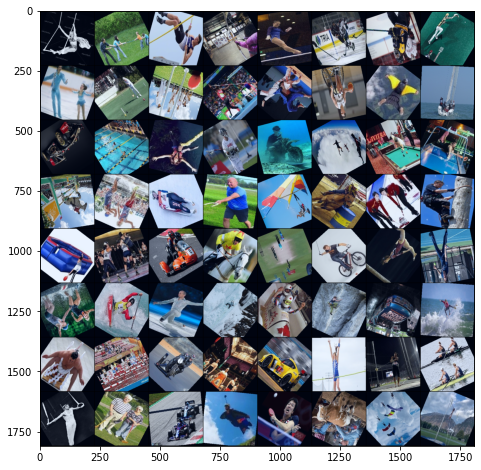

In [18]:
# Training set
visualize(train_dataloader)

## Create a model

In [19]:
class SportsNet(nn.Module):
    def __init__(self):
        super(SportsNet, self).__init__()
        self.model = nn.Sequential(
            # First Convolutional Layer
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),  # Batch normalization for 96 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Second Convolutional Layer
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),  # Batch normalization for 256 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Third Convolutional Layer
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),  # Batch normalization for 384 channels
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2), 


            # Fourth Convolutional Layer
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),  # Batch normalization for 384 channels
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2), 


            # Fifth Convolutional Layer
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization for 256 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Flatten and Fully Connected Layers
            nn.Flatten(),
            nn.Linear(in_features=6400, out_features=4096),
            nn.BatchNorm1d(4096),  # Batch normalization for fully connected layer
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(in_features=4096, out_features=2048),
            nn.BatchNorm1d(2048),  # Batch normalization for fully connected layer
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(in_features=2048, out_features=100),  # Output layer
        )

    def forward(self, x):
        return self.model(x)

# Create model instance
model = SportsNet().to(device)

# Display model summary
summary(model=model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SportsNet                                [32, 100]                 --
├─Sequential: 1-1                        [32, 100]                 --
│    └─Conv2d: 2-1                       [32, 96, 54, 54]          34,944
│    └─BatchNorm2d: 2-2                  [32, 96, 54, 54]          192
│    └─ReLU: 2-3                         [32, 96, 54, 54]          --
│    └─MaxPool2d: 2-4                    [32, 96, 26, 26]          --
│    └─Conv2d: 2-5                       [32, 256, 26, 26]         614,656
│    └─BatchNorm2d: 2-6                  [32, 256, 26, 26]         512
│    └─ReLU: 2-7                         [32, 256, 26, 26]         --
│    └─MaxPool2d: 2-8                    [32, 256, 12, 12]         --
│    └─Conv2d: 2-9                       [32, 384, 12, 12]         885,120
│    └─BatchNorm2d: 2-10                 [32, 384, 12, 12]         768
│    └─ReLU: 2-11                        [32, 384, 12, 12]         -

## Training the model

In [20]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [21]:
# train model
epochs = 40

training_loss = []
validation_loss = []

for epoch in range(epochs):

    # Training phase
    model.train()
    epoch_train_loss = 0.0
    for images, labels in train_dataloader:
        # Move data to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        train_loss = loss_fn(outputs, labels)

        # Backward pass
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item() * images.size(0)  # Accumulate loss

    # Average training loss for the epoch
    epoch_train_loss /= len(train_dataloader.dataset)
    training_loss.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for val_images, val_labels in validation_dataloader:
            # Move validation data to the appropriate device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            epoch_val_loss += val_loss.item() * val_images.size(0)  # Accumulate loss

    # Average validation loss for the epoch
    epoch_val_loss /= len(validation_dataloader.dataset)
    validation_loss.append(epoch_val_loss)

    # Print loss for the epoch
    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Epoch: 1/40, Training Loss: 3.9338, Validation Loss: 3.3119
Epoch: 2/40, Training Loss: 3.2412, Validation Loss: 2.9136
Epoch: 3/40, Training Loss: 2.9064, Validation Loss: 2.8023
Epoch: 4/40, Training Loss: 2.6444, Validation Loss: 2.5095


KeyboardInterrupt: 

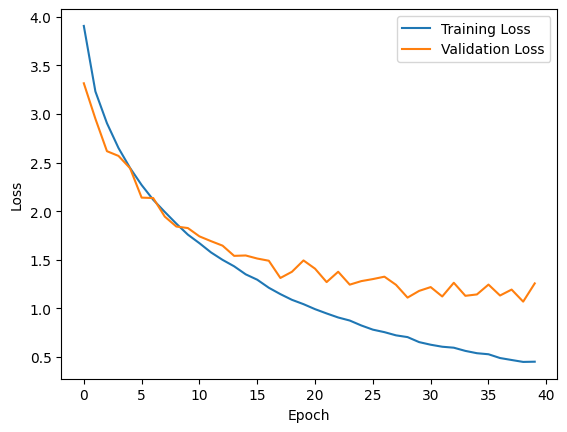

In [ ]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test the model

In [ ]:
# Test model on test set
predicted_labels = []
actual_labels = []

model.eval()  # Set the model to evaluation mode
with torch.inference_mode():  # Ensure no gradients are computed
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

Model Accuracy: 68.60%
Model Precision: 71.97%
Model Recall: 68.60%
Model F1 Score: 67.58%
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.80      0.80      0.80         5
           2       0.25      0.20      0.22         5
           3       1.00      0.40      0.57         5
           4       0.80      0.80      0.80         5
           5       1.00      0.60      0.75         5
           6       1.00      0.80      0.89         5
           7       1.00      0.20      0.33         5
           8       0.50      0.80      0.62         5
           9       0.33      0.40      0.36         5
          10       0.50      0.20      0.29         5
          11       1.00      1.00      1.00         5
          12       0.67      0.40      0.50         5
          13       0.33      0.20      0.25         5
          14       0.00      0.00      0.00         5
          15       0.83      1.00      0.91 

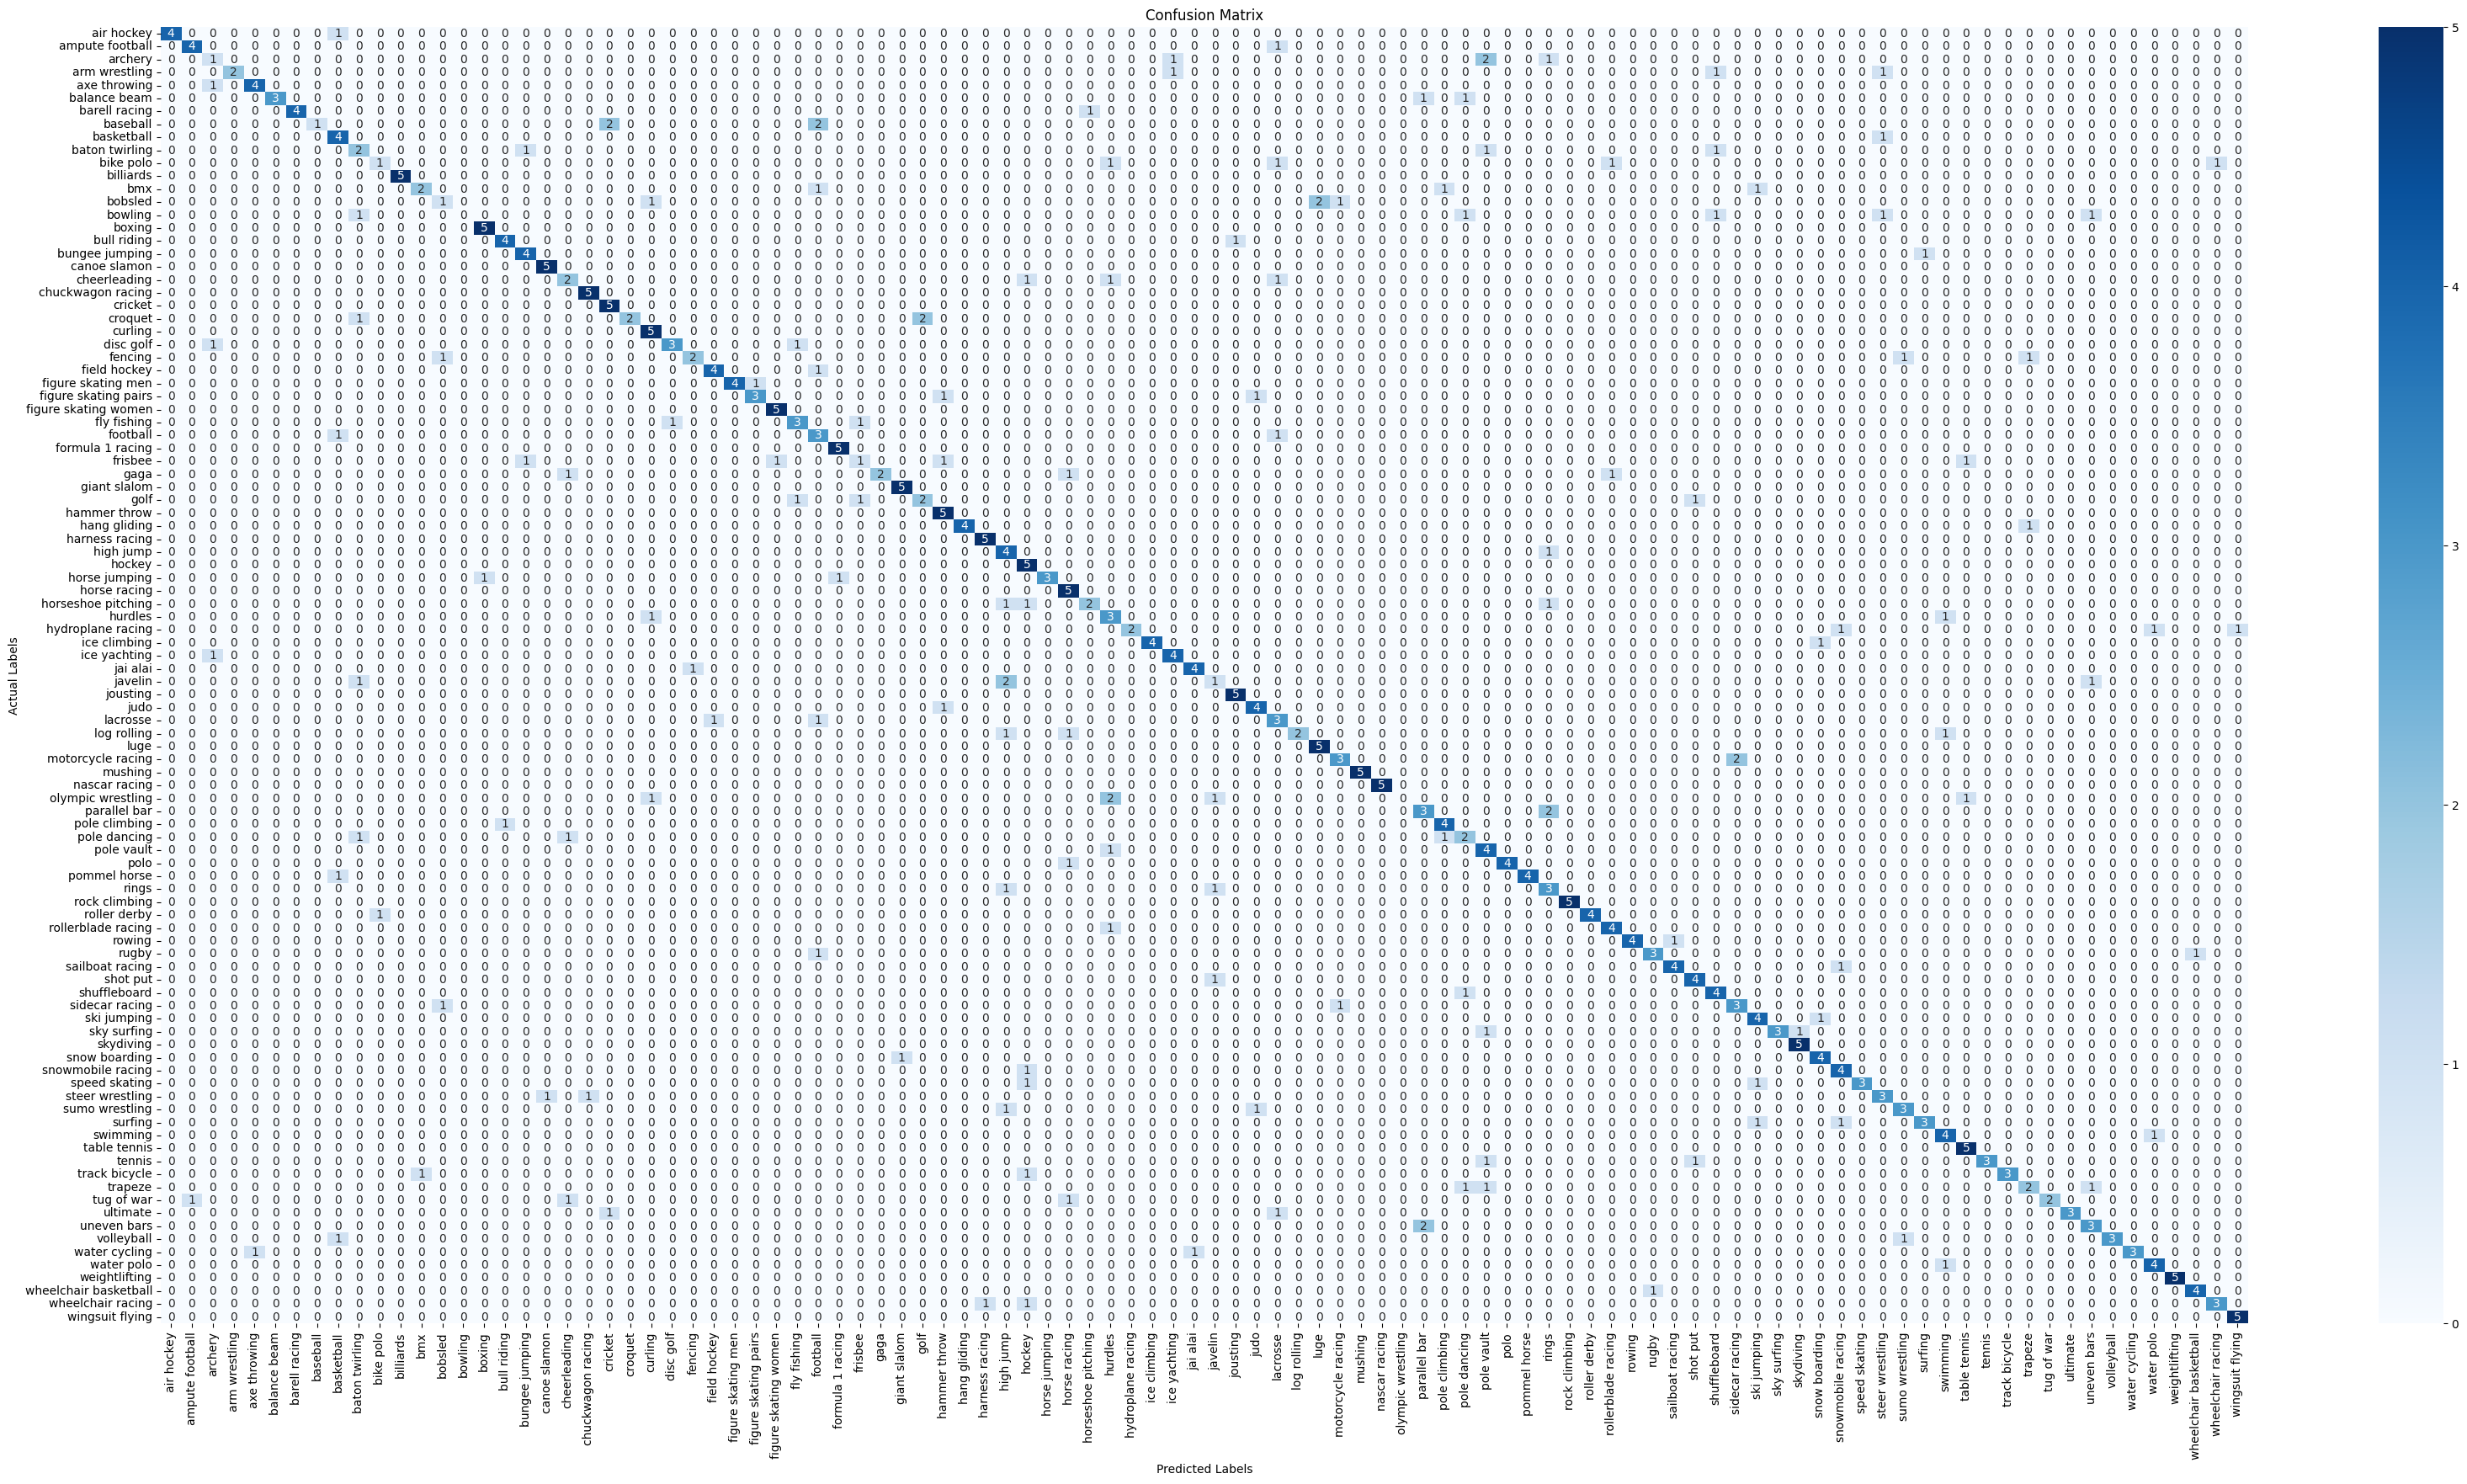

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

# Print metrics
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")

# Print classification report
print(classification_report(actual_labels, predicted_labels, zero_division=0))

# Generate and visualize confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
class_names = test_dataloader.dataset.classes

plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Model Test with Video

In [ ]:
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

video_path = "sports.mp4"
cap = cv2.VideoCapture(video_path)

frame_class_indices = []

with torch.no_grad():
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        input_tensor = transform(frame_rgb)
        input_batch = input_tensor.unsqueeze(0)

        outputs = model(input_batch)
        probs = F.softmax(outputs, dim=1)

        predicted_idx = torch.argmax(probs, dim=1).item()
        frame_class_indices.append(predicted_idx)

cap.release()

most_common_class_idx = max(set(frame_class_indices), key=frame_class_indices.count)

predicted_class_name = class_names[most_common_class_idx]
count_most_common = frame_class_indices.count(most_common_class_idx)
print(f"The video is predicted to be: {predicted_class_name} chsen {count_most_common} times out of {len(frame_class_indices)} frames.")
print(np.array(frame_predictions))